# 11 Parallel Programming on GPUs

In [1]:
from IPython.display import Image

In [2]:
%alias clean rm -f *.c *.exe *.py *.pyc *.s .*f95 *.o *.fo *log *.h *.cc *.mod *.ppm *.png temp_field_*

In [3]:
%clean

## Outline
[0 GPU architecture](#zero)  
[1 Offloading with OpenMP](#one)  
[2 CUDA](#two)  

<a id="zero"></a>

# GPU architecture

## Why GPUs became so hot?

GPUs were sold in the '90s fot the gaming market. They were designed specifically for graphics and allowed minimum operations and programming. 
GPUs could *only* process independent geometric elements, but could process *many* of them in parallel. 

Another case of data parallelism. Can general purpose computations be executed on GPUs? Is that new?

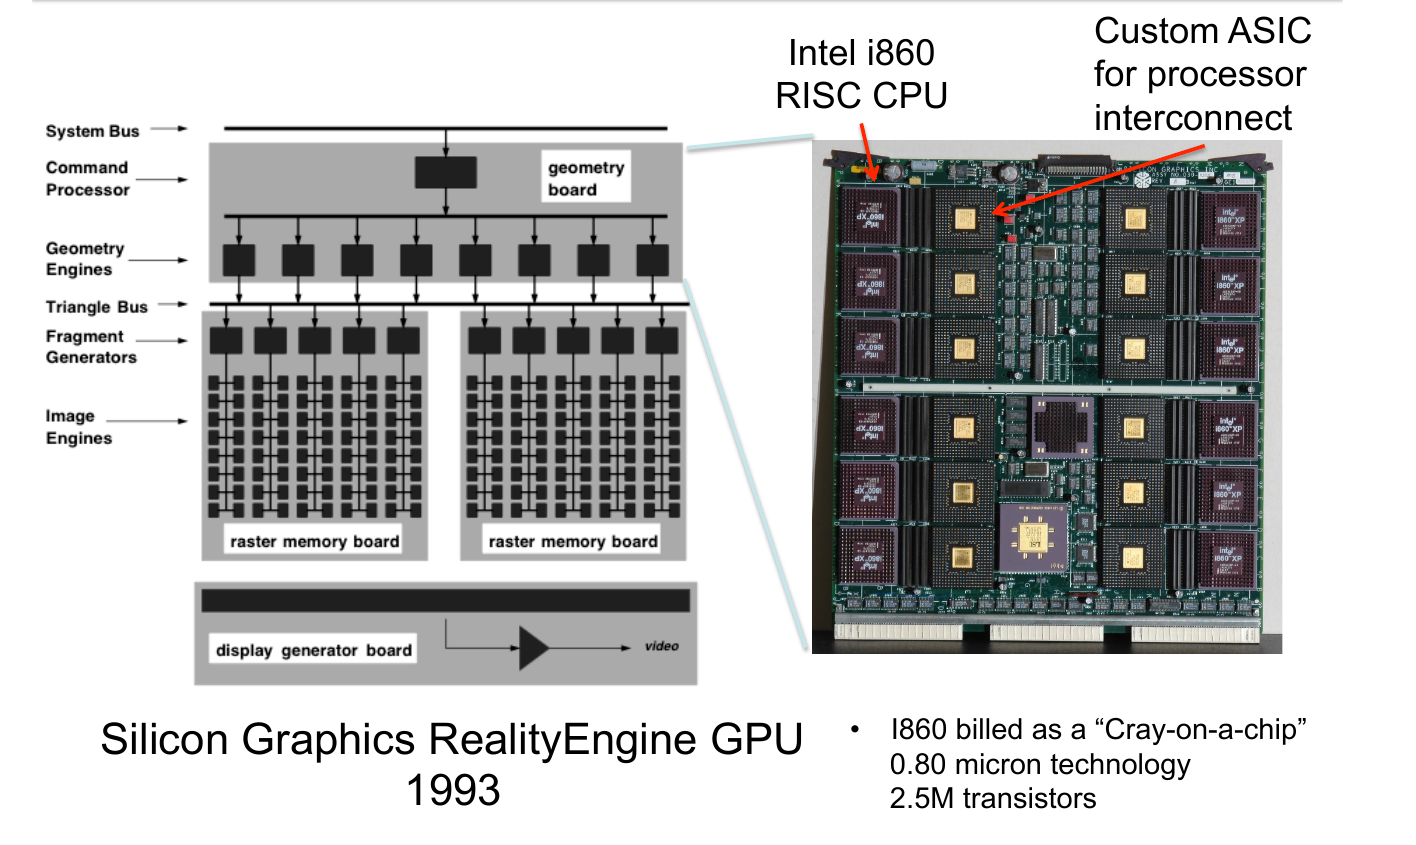

In [4]:
Image("pictures/sgi.png")

Why it became so hot then since 2006?

... Moore' Law. The same equipment that cost 1M$ now cost 3 hundred.

**Generation 1: Vodoo (1996)**

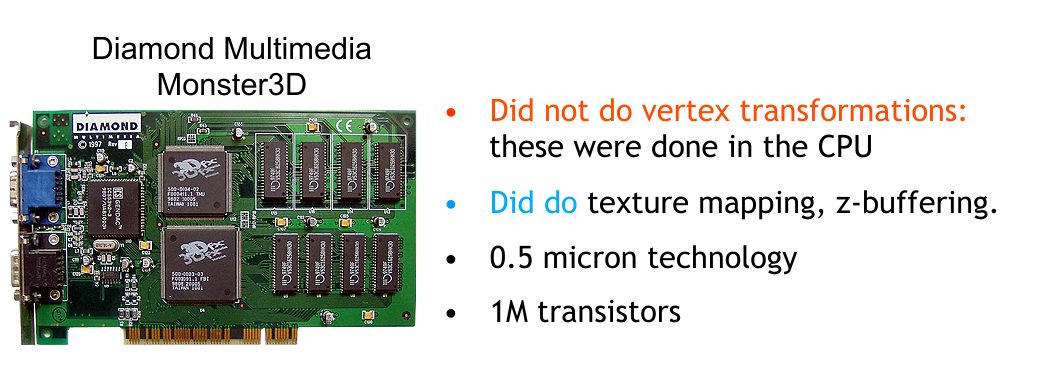

In [2]:
Image("pictures/vodoo.png")

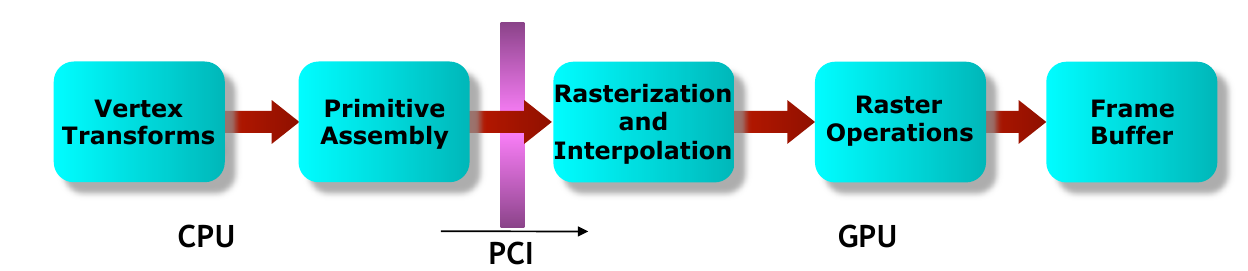

In [3]:
Image("pictures/graphic_pipeline_0.png")

**Generation 2: Geforce 256 (2001)**

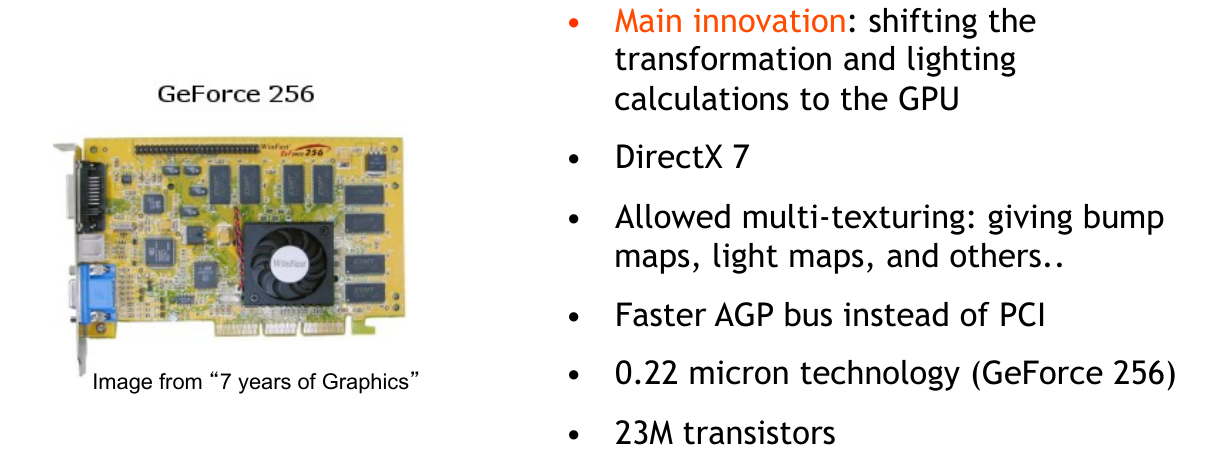

In [5]:
Image("pictures/geforce_256.png")

**Generation 3: Geforce3 / Radeon 8500 (2001)**

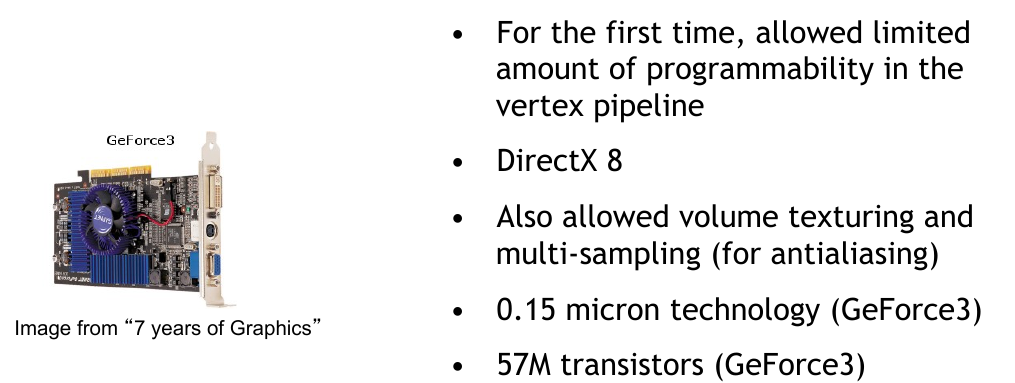

In [4]:
Image("pictures/geforce3.png")

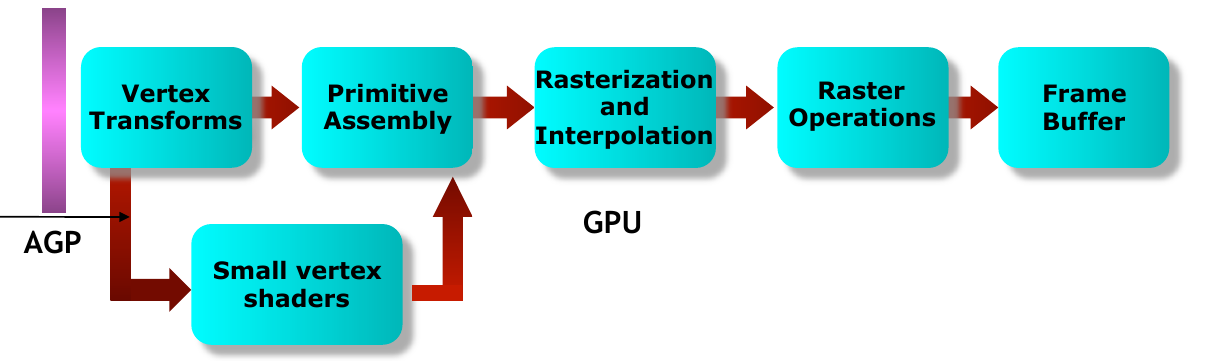

In [5]:
Image("pictures/graphic_pipeline.png")

**Generation IV: Radeon9700 / Geforce 4 (2002)**

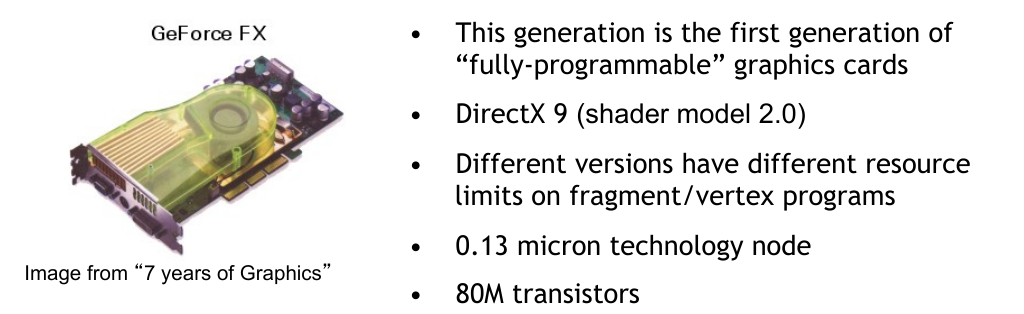

In [6]:
Image("pictures/radeon9700.png")

**Generation V: Geforce 8800 (2006)**

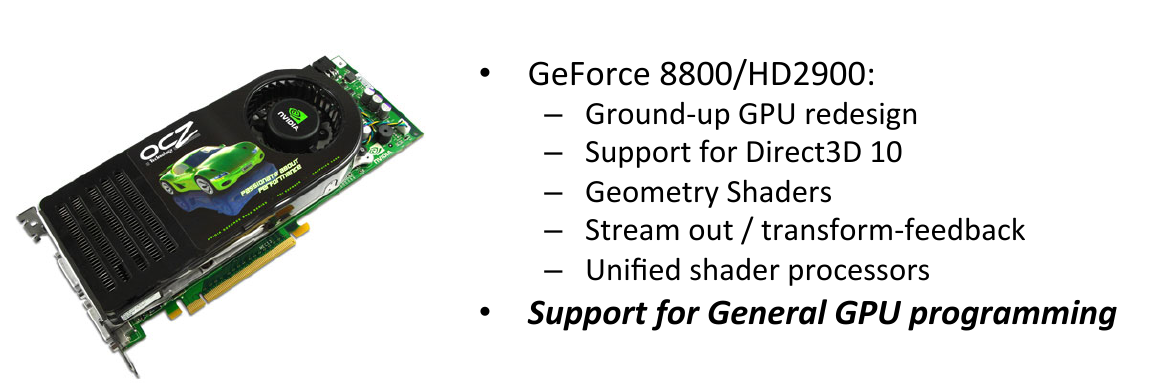

In [9]:
Image("pictures/geforce_8800.png")

## GPUS internal layout

GPUs are made of independent parts, known as **Streaming Multiprocessors** (**SMs**).  
Threads are organized into **threadblocks**.  
Threads within the same theadblock run on an SM and can synchronize.
Threads in different threadblocks (even if they’re on the same SM) cannot synchronize.

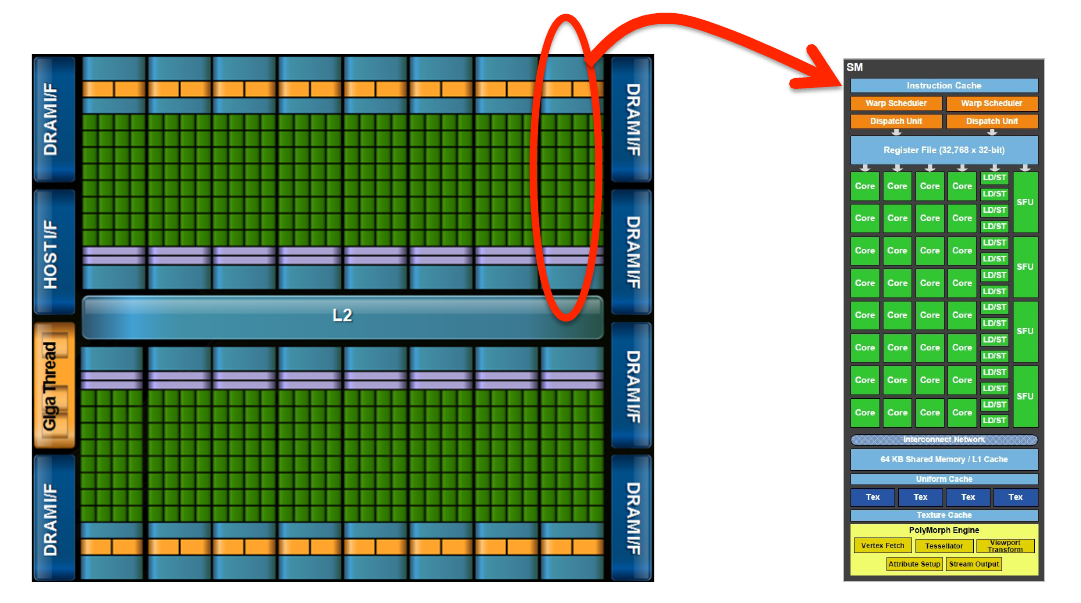

In [10]:
Image("pictures/SM.png")

**Execution model**

The *Host* defines a command queue and associates it with a context (devices, kernels, memory, etc) and enqueues commands to the command queue.  
Kernel execution commands launch work-items: i.e. a kernel for each point in an abstract Index Space called an NDRange.  
Work items execute together as a work-group.  

This is *OpenCL* jargon. *CUDA* calls the command queue a *CUDA Stream* and kernel execution creates *threads* organized in *thread block*. The NDRange becomes a *Grid*.

OpenMP uses *teams* and *leagues*...  
OpenAcc has *gangs* ...  

and what in the future? bunches? clans?  
(I humbly despise when people names with 1000 names the same thing)

**Single Instruction Multiple Thread**

GPUs use a IMT model, where	individual scalar instruction streams for each CUDA thread are grouped together for SIMD execution on hardware (Nvidia groups 32 CUDA threads into a warp).	

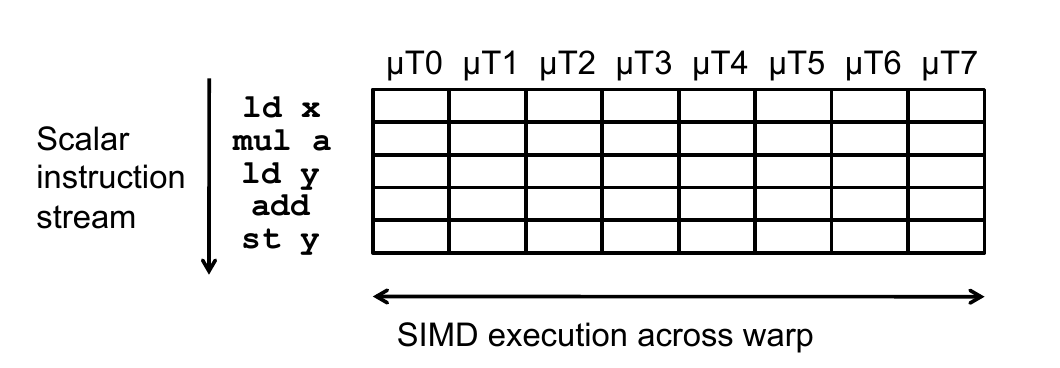

In [11]:
Image("pictures/warp.png")

- Individual threads of a	warp start together at the same program address.  
- Each thread has its own instruction address counter and register state.  
- Each thread is free to branch and execute independently.  
- Each branch will be executed serially.  
- Threads not following	the	current	branch will be disabled.  

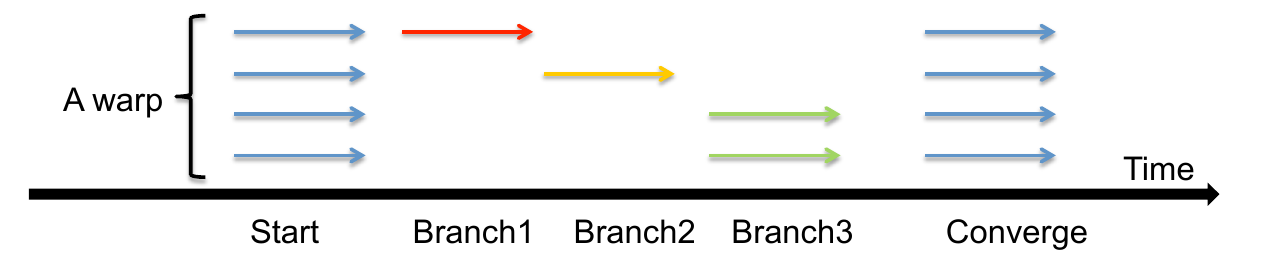

In [12]:
Image("pictures/branch.png")

CUDA is a heterogeneous programming	model sequential code runs in the “Host Thread” on a CPU core, and the "Device" code runs on the many cores	of the GPU.  
The Host and the Device communicate via a PCI Express (PCI/E) link. It has high	latency and low	bandwidth hence is desirable to	minimize the amount of data	transferred	and	the number of transfers.  

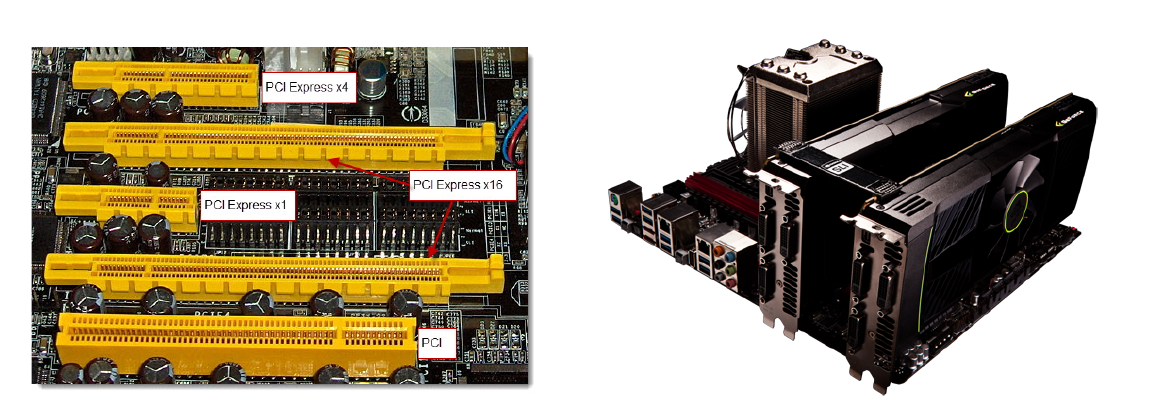

In [7]:
Image("pictures/pci_e.png")

**Current GP-GPU models**

*GeForce 10 series*. [Pascal](#https://en.wikipedia.org/wiki/Pascal_(microarchitecture)) and [Volta](#https://en.wikipedia.org/wiki/Volta_(microarchitecture)) microarchitectures. Launched 2016.  
*Geforce 20 series* [Touring](#https://en.wikipedia.org/wiki/Turing_(microarchitecture)) microarchitecture coming out now (Q4 2018)


Current high end GPGPU: https://www.nvidia.com/en-us/data-center/tesla-v100/.

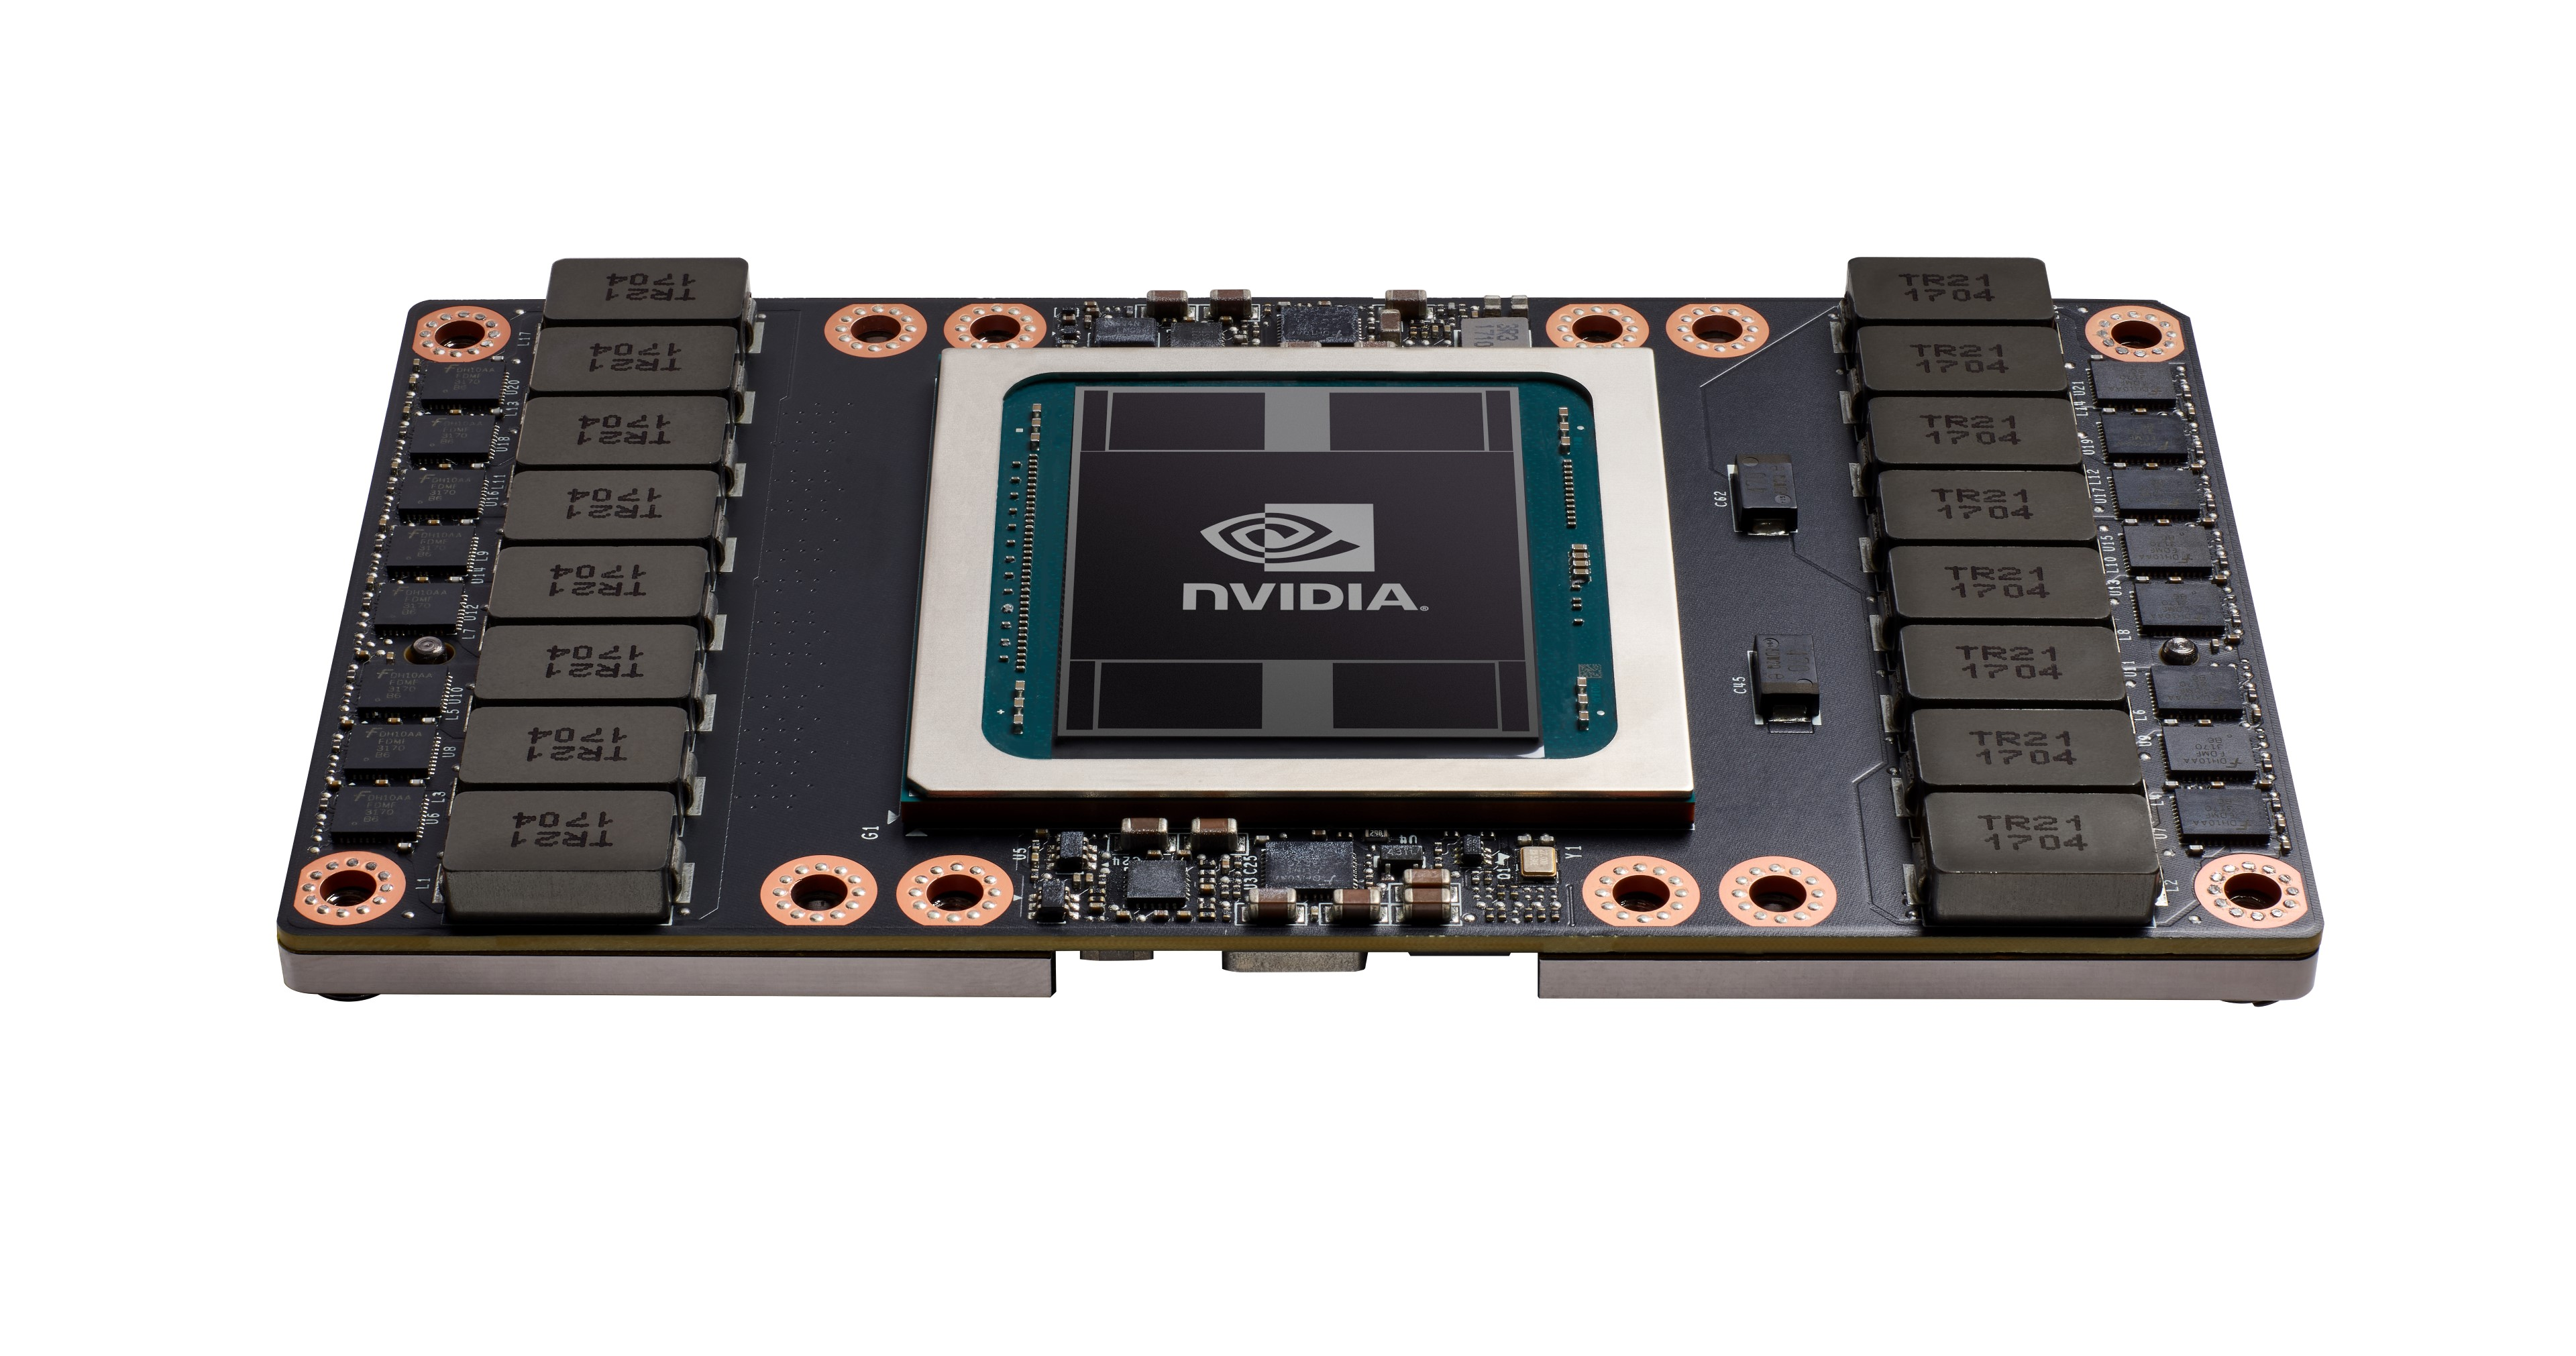

In [12]:
Image("pictures/Tesla_V100_SXM_FrontTop-Custom.jpg")

## Intel Xeon $\Phi$

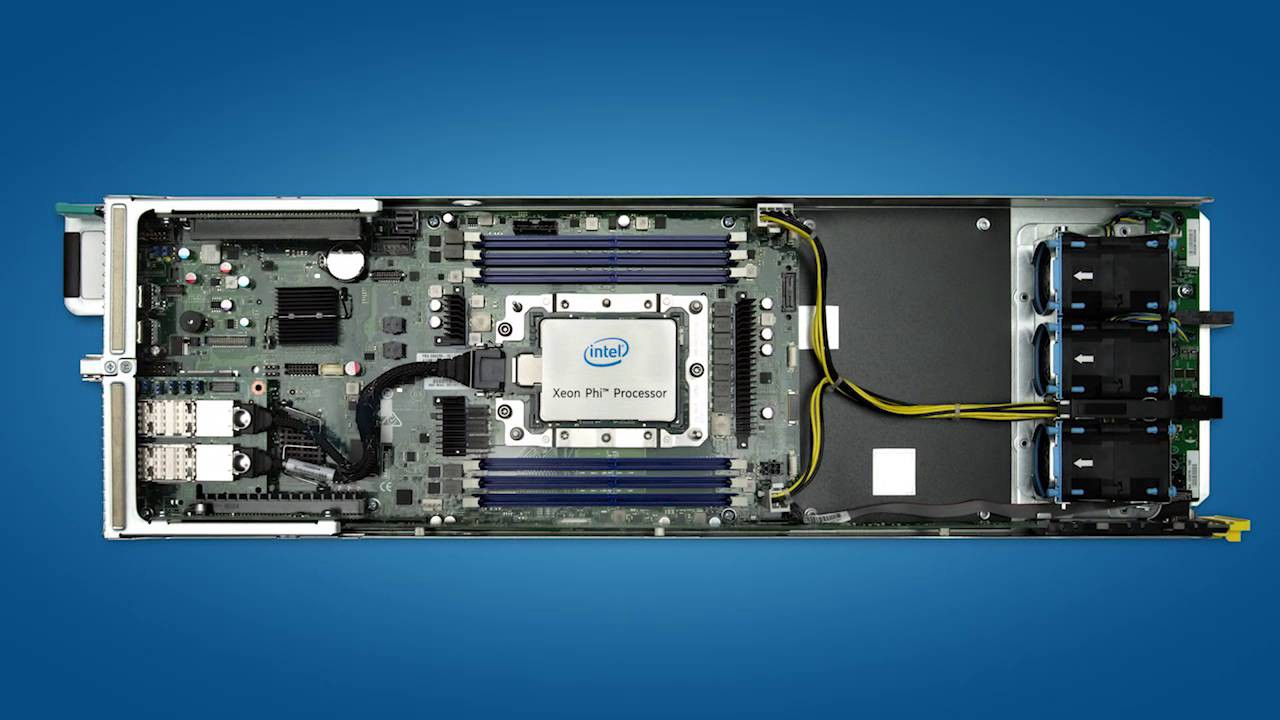

In [9]:
Image("pictures/xeonphi.jpg")

- It is a *coprocessor*, not a *GPU or accelerator*.  
- The architecture is named *MIC* (Many Integrated Cores). Xeon Phi is the brand name of the product.   
- Comparable to Intel64 on CPU side

- 2008 - Larrabee GPGPU announced but never marketed.  
- 2010 - MIC and the Knight’s series announced. Re-architected for pure computing.  
        - Knight’s Ferry (KNF) development kit
- 2011 - Knight’s Corner (KNC) development kit
        - Alpha/beta versions of the final products
- 2012 - Intel Xeon Phi brand introduced
        - First products based on the KNC architecture
- 2016 - Knight’s Landing (KNL)

see also https://software.intel.com/en-us/articles/intel-xeon-phi-core-micro-architecture

- 10s of x86-based cores
- Hardware multithreading
- Instruction set extensions for HPC
- Very high-bandwidth local GDDR5 memory

- Design the hardware for HPC.  
    - Strip out ”general purpose” CPU features.  
- Elaborate branch prediction, out-of-order execution etc.  
- Leverage existing x86 architecture and programming models.  
- *Enable development using common code base*.  
    - Same tools and libraries as on CPU.  
    - Same parallel paradigms (OpenMP, Cilk etc.).  
- Optimization strategies similar to CPU ones.  
- *Optimizations for Phi tend to improve CPU performance*.  

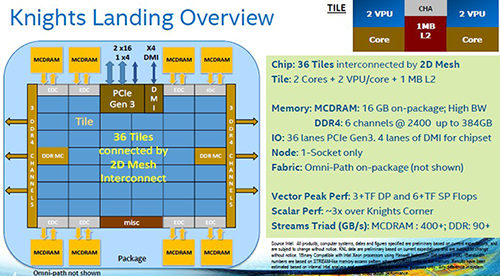

In [10]:
Image("pictures/HPCR_010_KnightsLanding.png")

**MIC vs CPU**
- Larger amount of simpler cores at a lower clock rate
    - Much less memory per core
    - Similar memory bandwidth per core
- In order execution:
    - Thread waits (stalls) on L1 cache miss
    - Sophisticated HW prefetching helps
- **2x wider vectors than AVX/AVX2**
    - Also richer set of vector instructions (FMA, mask etc.)
    - Exploiting this fully is essential for performance on MIC
    - Using 2-4 threads per core is essential
    - Using just 1 thread gives 50% performance
    - Can hide some of the latency caused by stalls    

**MIC vs GPU**

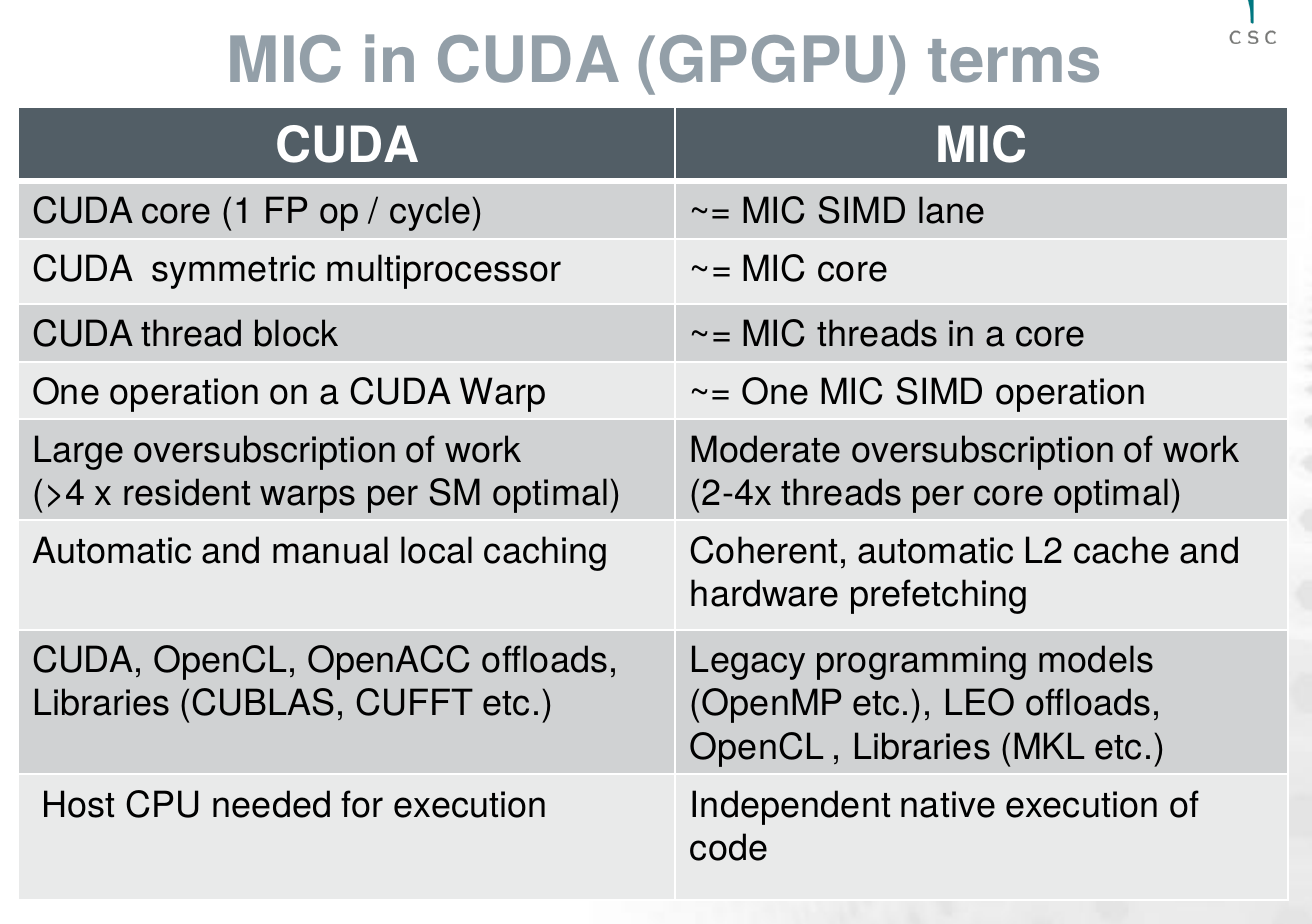

In [8]:
Image("pictures/mic_vs_gpu.png")

<a id="one"></a>

# Offloading to devices with OpenMP 4.5

OpenMP 4.0/4.5 supports heterogeneous systems (accelerators/devices)

Why OpenMP?

- to program a GPU: you have to use CUDA, OpenCL, OpenGL, DirectX,Intrinsics, C++AMP, OpenACC.  
- to program a host SIMD unit: you have to use Intrinsics, OpenCL, or autovectorization (`-ftree-vectorize`)
- to program the CPU threads, you might use C/C++11, OpenMP, TBB, Cilk, pthreads and many others

With OpenMP 4.5 and up:
- you can use the same standard to program the GPU, the SIMD units, and the CPU threads


*Device*:  
- An implementation-defined (logical) execution unit (or accelerator).  

*Device data environment*:
- Storage associated with the device.  

*The execution model is host-centric (or initial device)*:  
- Host creates/destroys data environment on device(s).  
- Host maps data to the device(s) data environment.  
- Host offloads OpenMP target regions to target device(s).  
- Host updates the data between the host and device(s).  

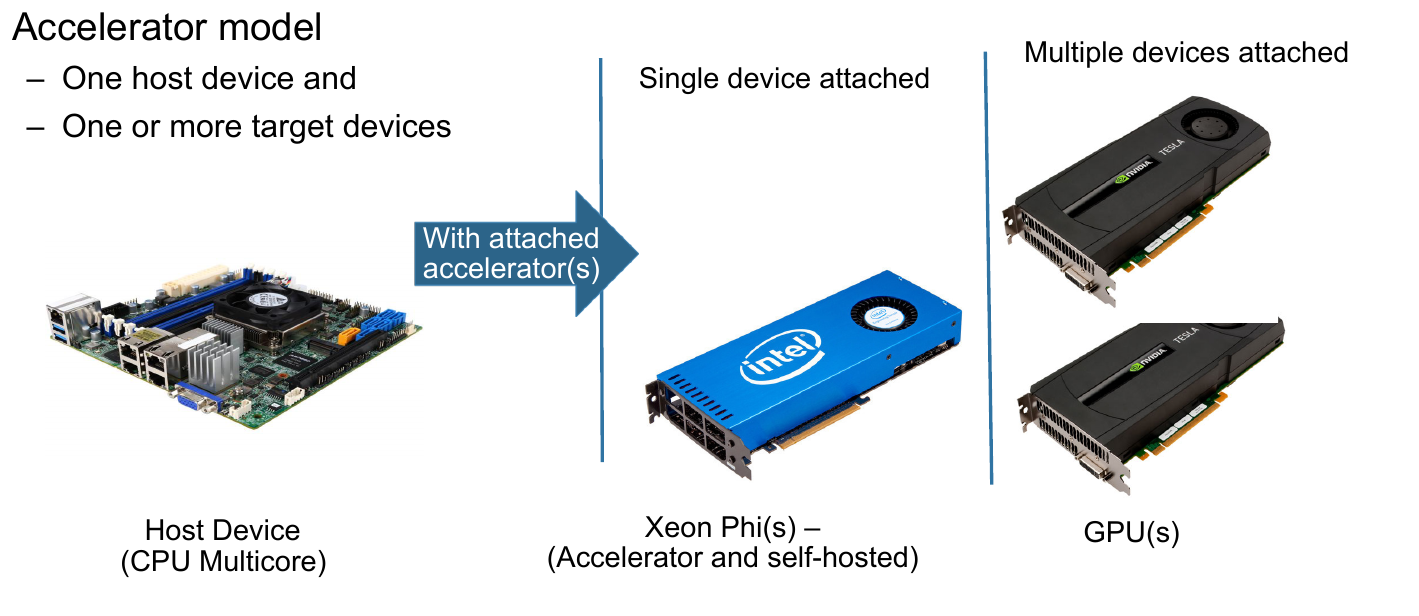

In [5]:
Image("pictures/ompaccel.png")

    #pragma omp target map(to:u) map(from:uold) // the enclosed stack goes on the device
    {
        #pragma omp parallel for collapse(2)
        for(int i = 0; i < N; i++)
            for(int j = 0; j < N; j++)
                compute(A[i][j]);
    }

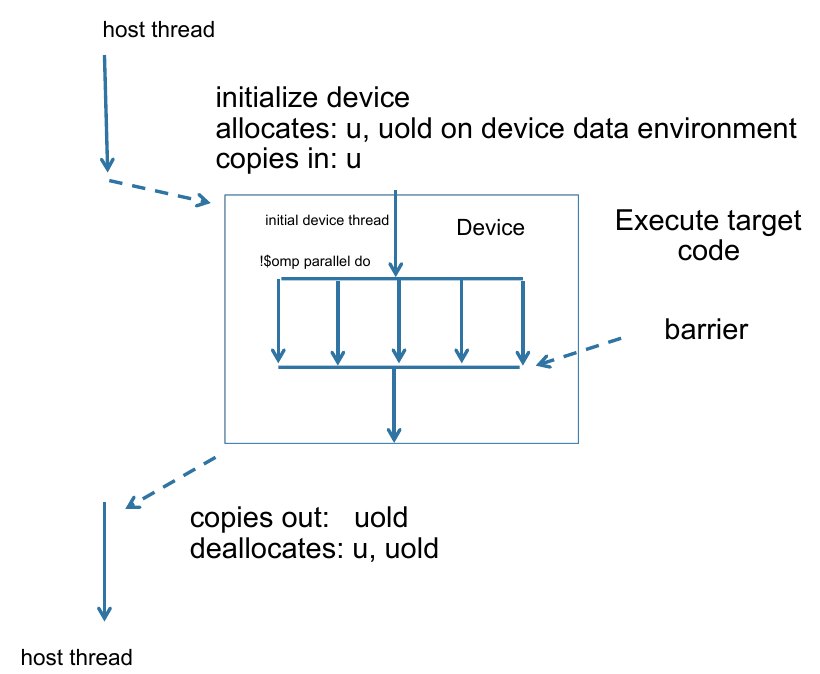

In [6]:
Image("pictures/exec_model.png")

**map** clause

*Mapped variable*: an original variable in a (host) data environment has a corresponding variable in a device data
environment
*Mapped type*:
- A type that is amenable for mapped variables
- Bitwise copy-able plus additional restrictions

### League and teams of threads

**Team**:  
- A set of threads created for each streaming multiprocessor.  

**League**: 
- Set of thread teams created by a teams construct.

**Contention group**:
- Threads of a team in a league and their descendant threads.  
- Threads can synchronize in the same contention group.  

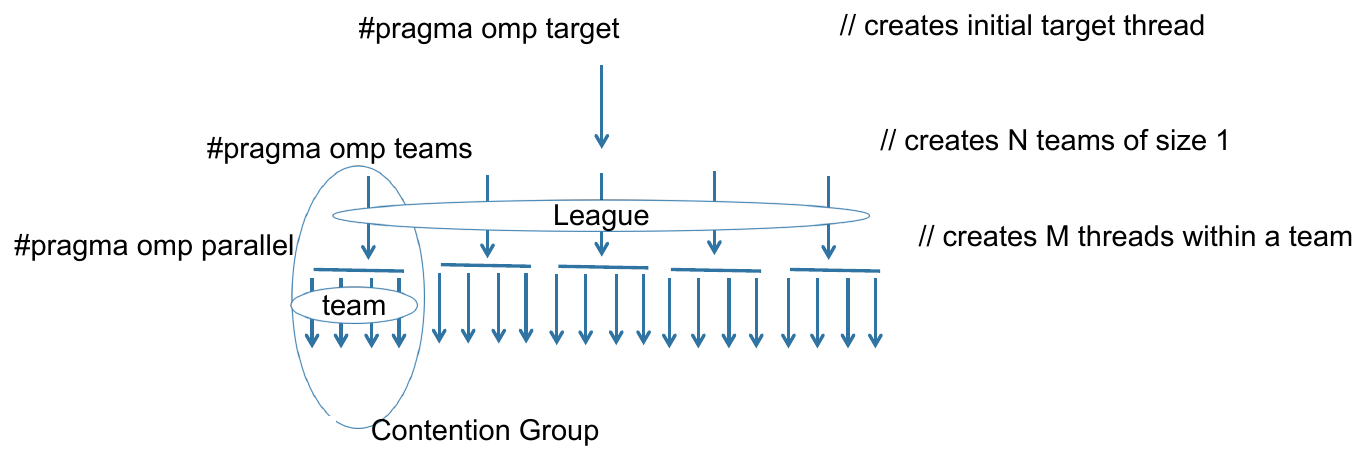

In [9]:
Image("pictures/league.png")

**teams** construct.  

The `teams` construct creates a league of thread teams:  
- The master threads of all teams executes the team region.  
- The number of teams is specified by the `num_teams` clause.  
- Each team executes with thread_limit threads.  
- Threads in different teams cannot synchronize with each other.  
- Must be perfectly nested in a target construct.  
- No statements or directives between teams and target constructs.  

Only special openmp constructs can be nested inside a teams construct:
- **distribute**
- parallel
- parallel for
- parallel sections

**distribute** construct:
- Work-sharing construct for target and teams regions.  
- Distribute the iterations of a loop *across the master threads of the teams* executing the region.  
- No implicit barrier at the end of the construct.  

`dist_schedule(kind[, chunk_size])`
- kind must be static scheduling.  
- Chunks are distribute in round-robing fashion with chunk_size.  
- Each team receives at least one evenly distributed chunk (if no chunk_size is specified).  

    #pragma omp target map(tofrom: A)
    #pragma omp teams
    #pragma omp distribute
    for (i=0; i< N; i++)
        compute(A[i]);

    #pragma omp target map(tofrom: A)
    #pragma omp teams distribute parallel for simd collapse(3) 
    for (i=0; i< N; i++)
        for (j=0; i< M; j++)
            for (k=0; k< L; k++)
                compute(A[i][j][k]);

using defaults (e. g. with preprocessor directives) for `num_teams` you can adapt to different environments

**Example: hello world offload**

**Example: dot product**

**Example: dense matrix multiplication**

In [ ]:
TODO
pointers and copy
structures
choose devices
Exercise: Jacobi

<a id="two"></a>

## CUDA